In [2]:
import os
import time
import warnings
import ast
from collections import Counter
from datetime import datetime

import pandas as pd
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.common.exceptions import NoSuchElementException, TimeoutException, ElementClickInterceptedException
from webdriver_manager.chrome import ChromeDriverManager


In [3]:
# 현재 작업 디렉토리 경로 얻기
current_directory = os.getcwd()
# 나눔바른고딕 글꼴 파일 경로 지정
font_path = os.path.join(current_directory, "NanumBarunGothic.ttf")

# 글꼴이 있는지 확인
if os.path.exists(font_path):
    # 폰트 추가
    fm.fontManager.addfont(font_path)

    # 캐시를 새로 고치지 않고 직접 폰트 설정
    font_prop = fm.FontProperties(fname=font_path)
    plt.rc("font", family=font_prop.get_name())
    plt.rcParams["axes.unicode_minus"] = False  # 마이너스 부호 출력 설정

In [4]:
# 인터파크 Dataset
ip_df = pd.read_csv('D:\workspace\M3_분석라이브러리\Interpark_books_dataset.csv')
ip_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23899 entries, 0 to 23898
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Publisher  23899 non-null  object
 1   Category   23899 non-null  object
 2   Title      23899 non-null  object
 3   Sales      23899 non-null  object
 4   Year       23899 non-null  int64 
 5   Month      23899 non-null  int64 
 6   Age        23899 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 1.3+ MB


In [5]:
# Yes24 Dataset
yes_df = pd.read_csv('D:\workspace\M3_분석라이브러리\yes24_bestseller_data_final.csv')
yes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13620 entries, 0 to 13619
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Year          13620 non-null  int64  
 1   Month         13620 non-null  int64  
 2   Category      13620 non-null  object 
 3   Title         13620 non-null  object 
 4   Author        13620 non-null  object 
 5   Publisher     13620 non-null  object 
 6   Price         13620 non-null  int64  
 7   Publish_Date  13620 non-null  object 
 8   Sales_Index   13620 non-null  int64  
 9   Rating        13620 non-null  float64
 10  Age_Scores    13620 non-null  object 
 11  Pages         13572 non-null  object 
 12  Keywords      13620 non-null  object 
 13  Gender        13620 non-null  int64  
 14  Age           13620 non-null  int64  
 15  month         13620 non-null  int64  
dtypes: float64(1), int64(7), object(8)
memory usage: 1.7+ MB


In [29]:
yes_df.head()

,Year,Month,Category,Title,Author,Publisher,Price,Publish_Date,Sales_Index,Rating,Age_Scores,Pages,Keywords,Gender,Age,month
0,2024,1,가정과 살림,나는 다정한 관찰자가 되기로 했다,이은경 저,서교책방,16020,2024년 05월,237453,9.7,"{'10대': 0.0, '20대': 10.0, '30대': 9.0, '40대': 9...",288,"['#엄마가된다는것', '#엄마는처음이라', '#초보엄마', '#자녀교육']",1,10,6
1,2024,1,가정과 살림,성심당 케이크 레시피,안종섭 저,비앤씨월드,18000,2024년 05월,3060,9.1,{},228,"['#레시피', '#맛집레시피', '#디저트레시피북', '#베이킹', '#홈베이킹']",1,10,6
2,2024,1,가정과 살림,조이 오브 쿠킹,"이르마 S. 롬바우어, 존 베커, 메건 스콧 저/구계원 역",세미콜론,69300,2024년 02월,2076,9.8,{},"1,280","['#도시락레시피', '#반찬고민', '#간편요리', '#자취요리', '#집반찬']",1,10,6
3,2024,1,가정과 살림,10분 완성 초간단 도시락 레시피 100,오민주 저,시원북스,16020,2024년 02월,7914,9.9,"{'10대': 0.0, '20대': 0.0, '30대': 10.0, '40대': 9...",260,"['#크레마클럽에있어요', '#새해결심', '#집밥레시피', '#자취요리', '#싸...",1,10,6
4,2024,1,가정과 살림,뿐이 토핑 이유식,정주희 저/이수진 감수,서사원,26820,2024년 03월,89208,9.8,"{'10대': 0.0, '20대': 0.0, '30대': 9.0, '40대': 10...",640,"['#국민육아템', '#초보엄마', '#간편이유식']",1,20,6


## 전처리

In [6]:
# 결측치 평균값 채우기
yes_df['Pages'] = pd.to_numeric(yes_df['Pages'], errors='coerce')
mean_pages = yes_df['Pages'].mean()  # 평균값 계산

# 결측치를 평균값으로 채우기
yes_df['Pages'].fillna(mean_pages, inplace=True)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_6684\1002275636.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  yes_df['Pages'].fillna(mean_pages, inplace=True)


In [45]:
missing_values = yes_df.isnull().sum()
print(missing_values)

Year            0
Month           0
Category        0
Title           0
Author          0
Publisher       0
Price           0
Publish_Date    0
Sales_Index     0
Rating          0
Age_Scores      0
Pages           0
Keywords        0
Gender          0
Age             0
month           0
dtype: int64


In [17]:
# 가격 범주화
price_bins = [0, 10000, 15000, 20000, 30000, float('inf')]
price_labels = ['저가', '중저가', '중가', '고가', '최고가']
yes_df['Price_Range'] = pd.cut(yes_df['Price'], bins=price_bins, labels=price_labels, include_lowest=True)

# 페이지 범주화
page_bins = [0, 100, 200, 300, 500, float('inf')]
page_labels = ['동화', '단편', '중편', '장편', '초장편']
yes_df['page_labels'] = pd.cut(yes_df['Pages'], bins=page_bins, labels=page_labels, include_lowest=True)

# 새로운 칼럼 생성 (출판월, 계절)
def get_month(publish_date):
    return int(publish_date.split(' ')[1][:-1])

# 계절을 매핑하는 함수
def get_season(month):
    if month in [3, 4, 5]:
        return '봄'
    elif month in [6, 7, 8]:
        return '여름'
    elif month in [9, 10, 11]:
        return '가을'
    else:
        return '겨울'

# 월 추출
yes_df['Month'] = yes_df['Publish_Date'].apply(get_month)

# 계절 매핑
yes_df['Season'] = yes_df['Month'].apply(get_season)
season_order = ['봄', '여름', '가을', '겨울']

탐색적 분석 : 키워드(카테고리별 키워드 랭킹) / 책-가격&페이지수 상관관계 / 판매지수
          #    대분류 : 연령, 카테고리, 성별  - 소분류 : 가격, 키워드, 페이지수, 

시각화 : yes24 베스트셀러 한달치 데이터 연령대별 파이차트 (판매지수 활용). 
       성별, 취향(카테고리) 기반 시각화


## 연령대 - 선호카테고리
## 성별 - 선호카테고리(판매지수), 가격대, 책두께, 평점 

## 카테고리 : 연령대, 성별

In [50]:
yes_df['Price_Range'].value_counts()

Price_Range
중가     8046
중저가    2382
고가     1806
저가     1152
최고가     234
Name: count, dtype: int64

# 시각화

In [49]:
yes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Category      30 non-null     object  
 1   Title         30 non-null     object  
 2   Author        30 non-null     object  
 3   Publisher     30 non-null     object  
 4   Price         30 non-null     int64   
 5   Publish_Date  30 non-null     object  
 6   Sales_Index   30 non-null     int64   
 7   Rating        30 non-null     float64 
 8   Age_Scores    30 non-null     object  
 9   Pages         30 non-null     int64   
 10  Keywords      30 non-null     object  
 11  Gender        30 non-null     int64   
 12  Age           30 non-null     int64   
 13  Comments      30 non-null     object  
 14  month         30 non-null     int64   
 15  Price_Range   30 non-null     category
 16  page_labels   28 non-null     category
dtypes: category(2), float64(1), int64(6), object(8)
memory u

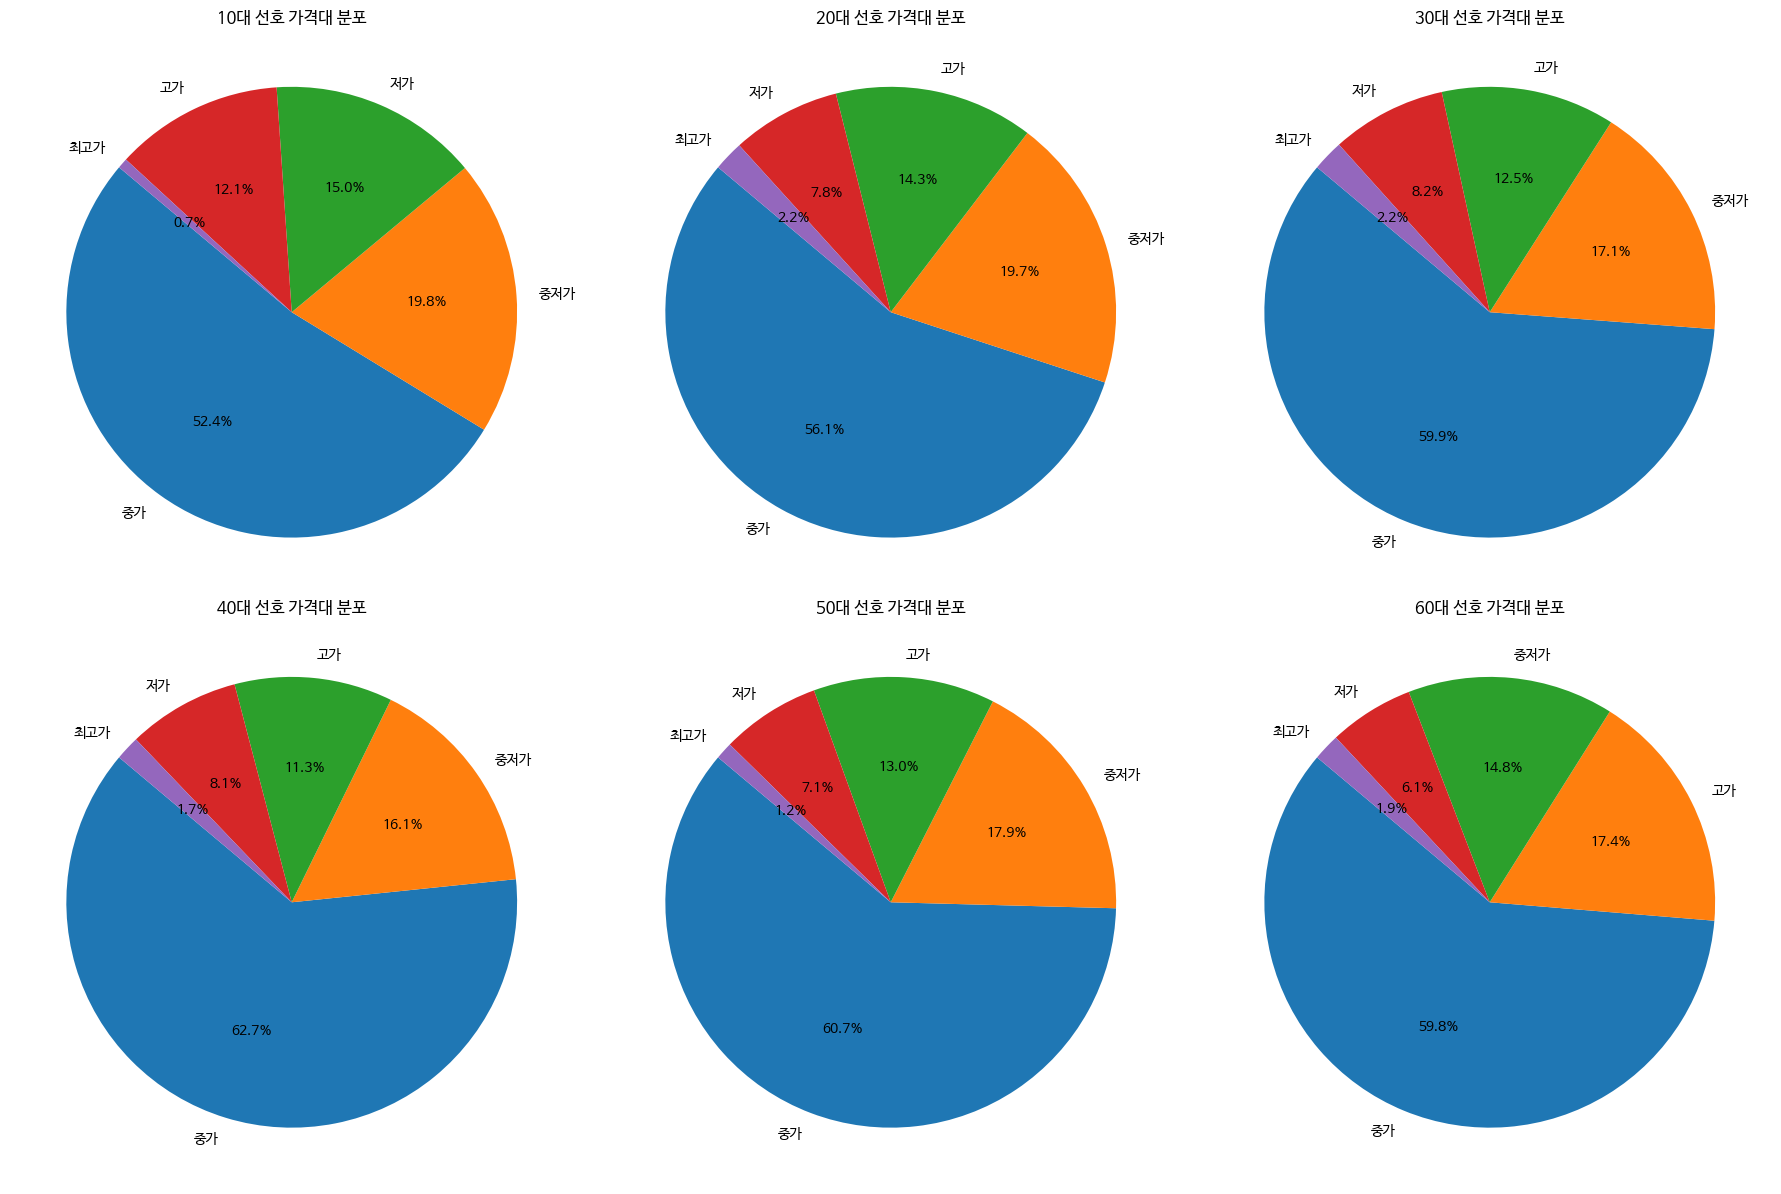

In [51]:
# 연령대별 가격 선호도 시각화
age_groups = yes_df['Age'].unique()
age_groups.sort()

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, age in enumerate(age_groups):
    age_group_data = yes_df[yes_df['Age'] == age]
    price_distribution = age_group_data['Price_Range'].value_counts(normalize=True)
    
    axes[i].pie(price_distribution, labels=price_distribution.index, autopct='%1.1f%%', startangle=140)
    axes[i].set_title(f'{age}대 선호 가격대 분포')

plt.tight_layout()
plt.show()

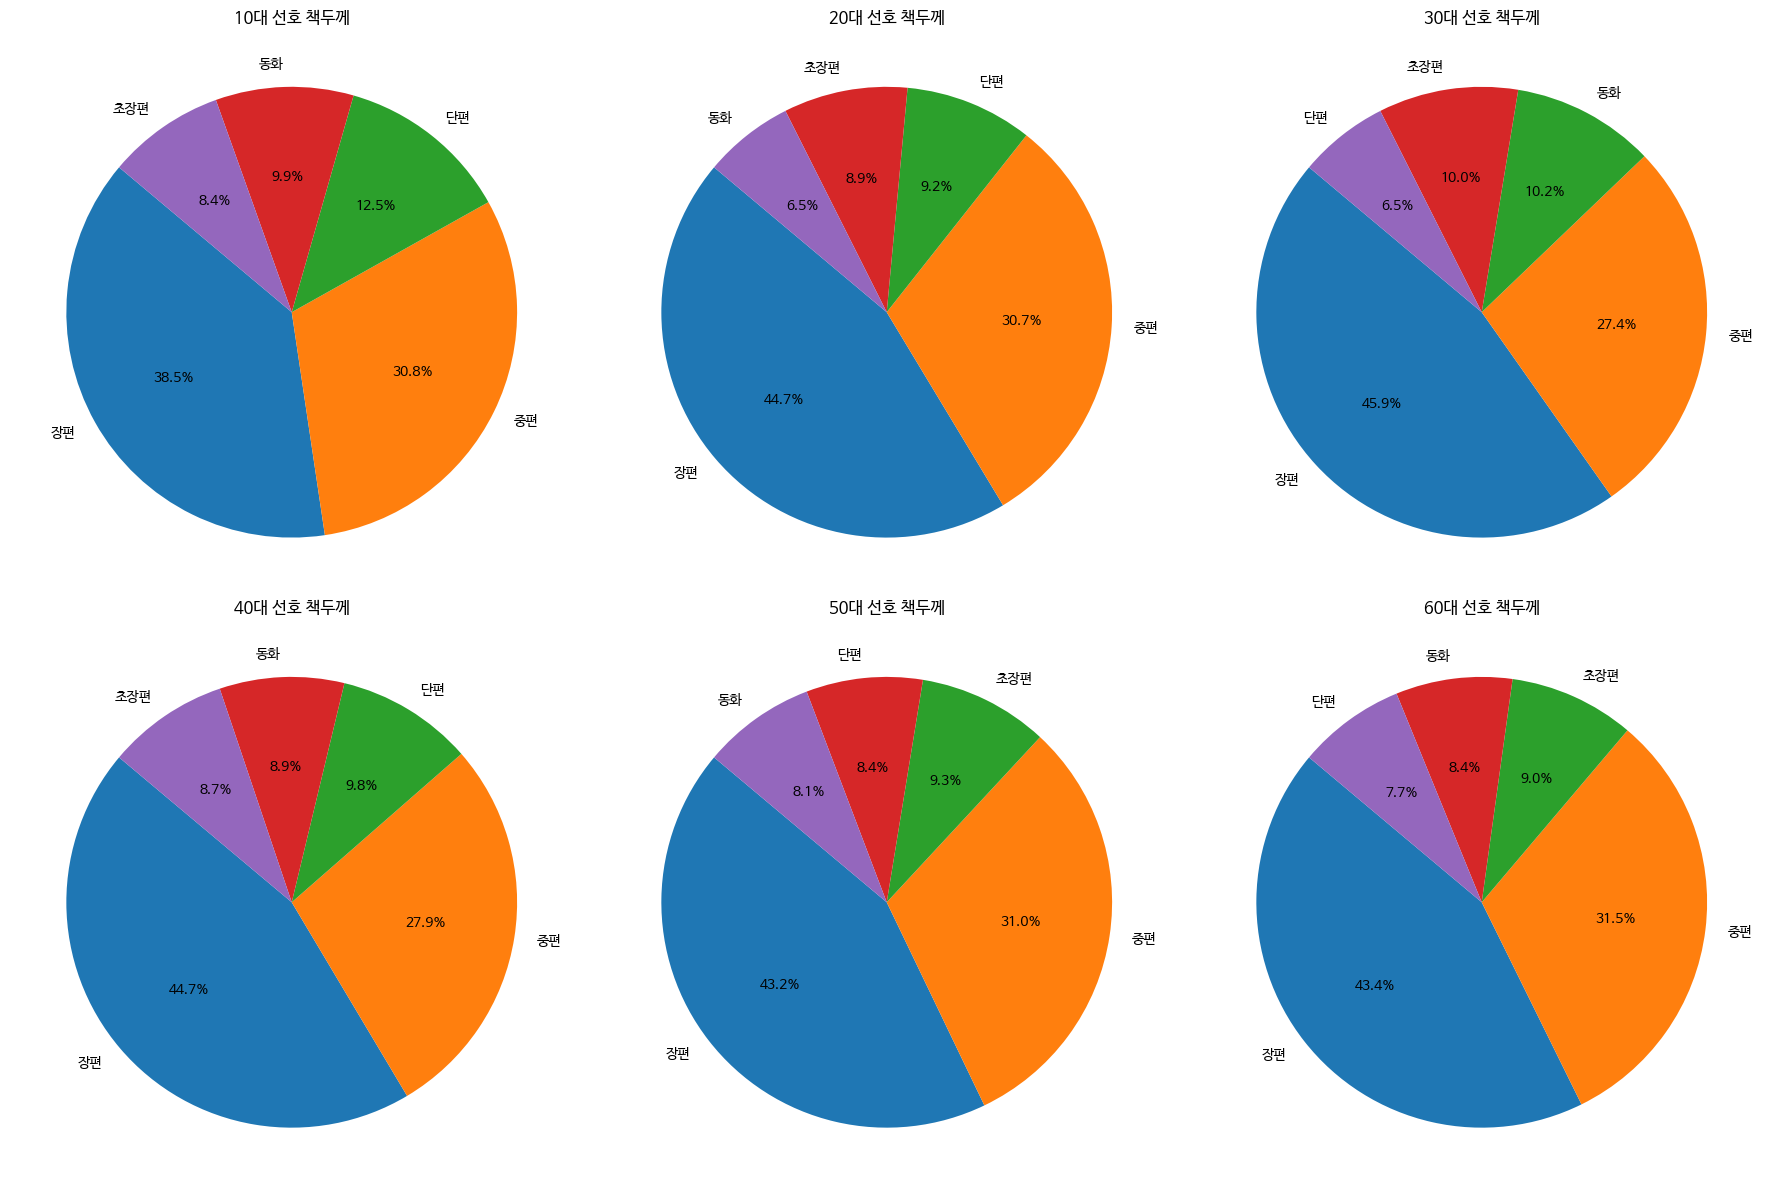

In [52]:
# 연령대별 페이지수 선호도 시각화
age_groups = yes_df['Age'].unique()
age_groups.sort()

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, age in enumerate(age_groups):
    age_group_data = yes_df[yes_df['Age'] == age]
    price_distribution = age_group_data['page_labels'].value_counts(normalize=True)
    
    axes[i].pie(price_distribution, labels=price_distribution.index, autopct='%1.1f%%', startangle=140)
    axes[i].set_title(f'{age}대 선호 책두께')

plt.tight_layout()
plt.show()

In [89]:
from collections import Counter
import ast

# 카테고리별 키워드 언급도
counter = Counter()

for keywords in yes_df['Keywords']:
    keywords_list = ast.literal_eval(keywords)
    counter.update(keywords_list)

# 결과 출력
for keyword, count in counter.items():
    print(f'{keyword} {count}')    

#엄마가된다는것 72
#엄마는처음이라 66
#초보엄마 84
#자녀교육 192
#레시피 18
#맛집레시피 30
#디저트레시피북 30
#베이킹 36
#홈베이킹 24
#도시락레시피 30
#반찬고민 66
#간편요리 84
#자취요리 18
#집반찬 6
#크레마클럽에있어요 1710
#새해결심 72
#집밥레시피 204
#싸고재밌고맛있게 6
#국민육아템 54
#간편이유식 102
#얼리리더 1308
#완밥레시피 42
#육아노하우 66
#친구선물 30
#결혼선물추천 30
#스테디에는이유가있다 192
#웰니스 54
#건강한식사 120
#건강식 150
#백선생 6
#메뉴가고민될때 6
#셰프의레시피 66
#오늘의한끼 6
#유튜버의책 120
#다이어트 78
#다이어트식단 66
#올해는다이어트성공할래 90
#아이를키운다면한번쯤 42
#육아백과사전 48
#부모는처음이라 78
#부모와아이가행복한육아 66
#부모가된다는것 90
#채소싫어하는아이 6
#아이입맛저격 18
#맘마먹자 36
#내맘대로올해의책 108
#올해의책 594
#일생의기술 24
#대화가필요해 36
#자녀와의대화 48
#두뇌발달 30
#아이랑뭐하고놀지? 24
#예술놀이 12
#핫플레이스 12
#부모교육 54
#유튜브인기레시피 84
#간단한레시피 42
#도시락을싸보자 24
#현실육아 48
#습관만들기 126
#좋은습관 150
#내손에잡지 30
#참여형그림책 36
#그림책읽는어른들에게 48
#그림책으로하는수업 30
#공부법 72
#효과적인공부법 54
#초등부터고등까지 48
#국어공부 42
#육아고수노하우 24
#아들키우기 24
#이달의굿즈 1518
#독서교육 42
#초등읽기 36
#문해력 120
#초등어휘 48
#어휘력 144
#홈스쿨링 18
#엄마표학습 18
#처음시작하는수학 24
#유아수학 18
#아이재우기 6
#수면건강 36
#초등글쓰기 18
#요리초보 12
#초보맘 6
#독서지도안 204
#국영수공부법 12
#속담 12
#초등한자 12
#공부법을공부하는부모 30
#학습법 12
#대학입시 42
#요즘부모양육법 6
#기간한정특가 

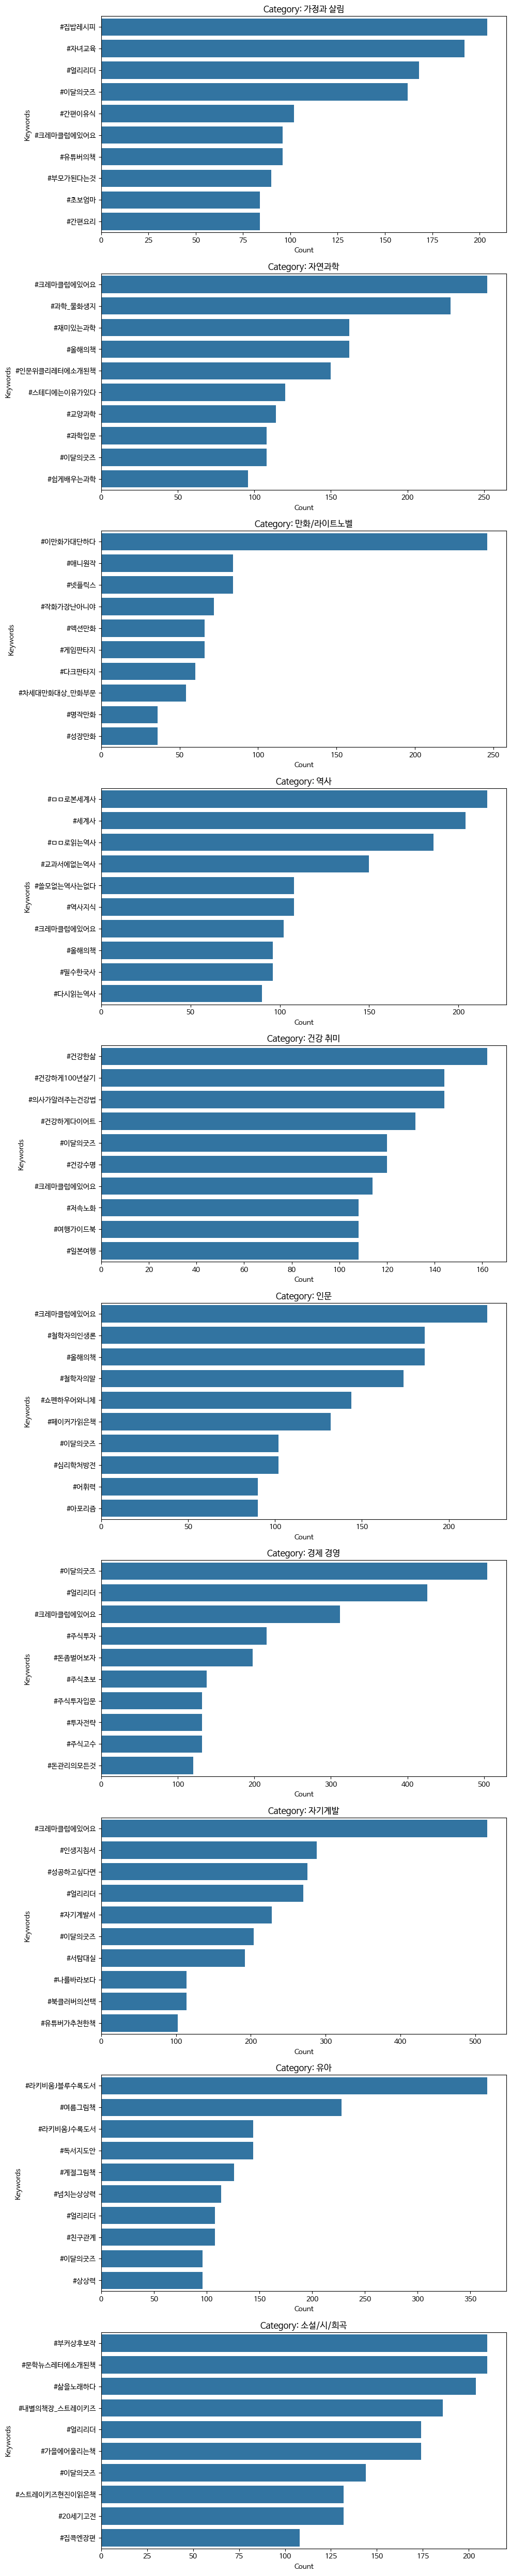

In [54]:
category_keyword_counter = {}

for category in yes_df['Category'].unique():
    counter = Counter()
    for keywords in yes_df[yes_df['Category'] == category]['Keywords']:
        keywords_list = ast.literal_eval(keywords)
        counter.update(keywords_list)
    category_keyword_counter[category] = counter.most_common(10)

# 결과 시각화
fig, axes = plt.subplots(nrows=len(category_keyword_counter), figsize=(10, 5*len(category_keyword_counter)))

if len(category_keyword_counter) == 1:
    axes = [axes]

for ax, (category, counter) in zip(axes, category_keyword_counter.items()):
    keywords, counts = zip(*counter)
    sns.barplot(x=list(counts), y=list(keywords), ax=ax)
    ax.set_title(f'Category: {category}')
    ax.set_xlabel('Count')
    ax.set_ylabel('Keywords')

plt.tight_layout()
plt.show()

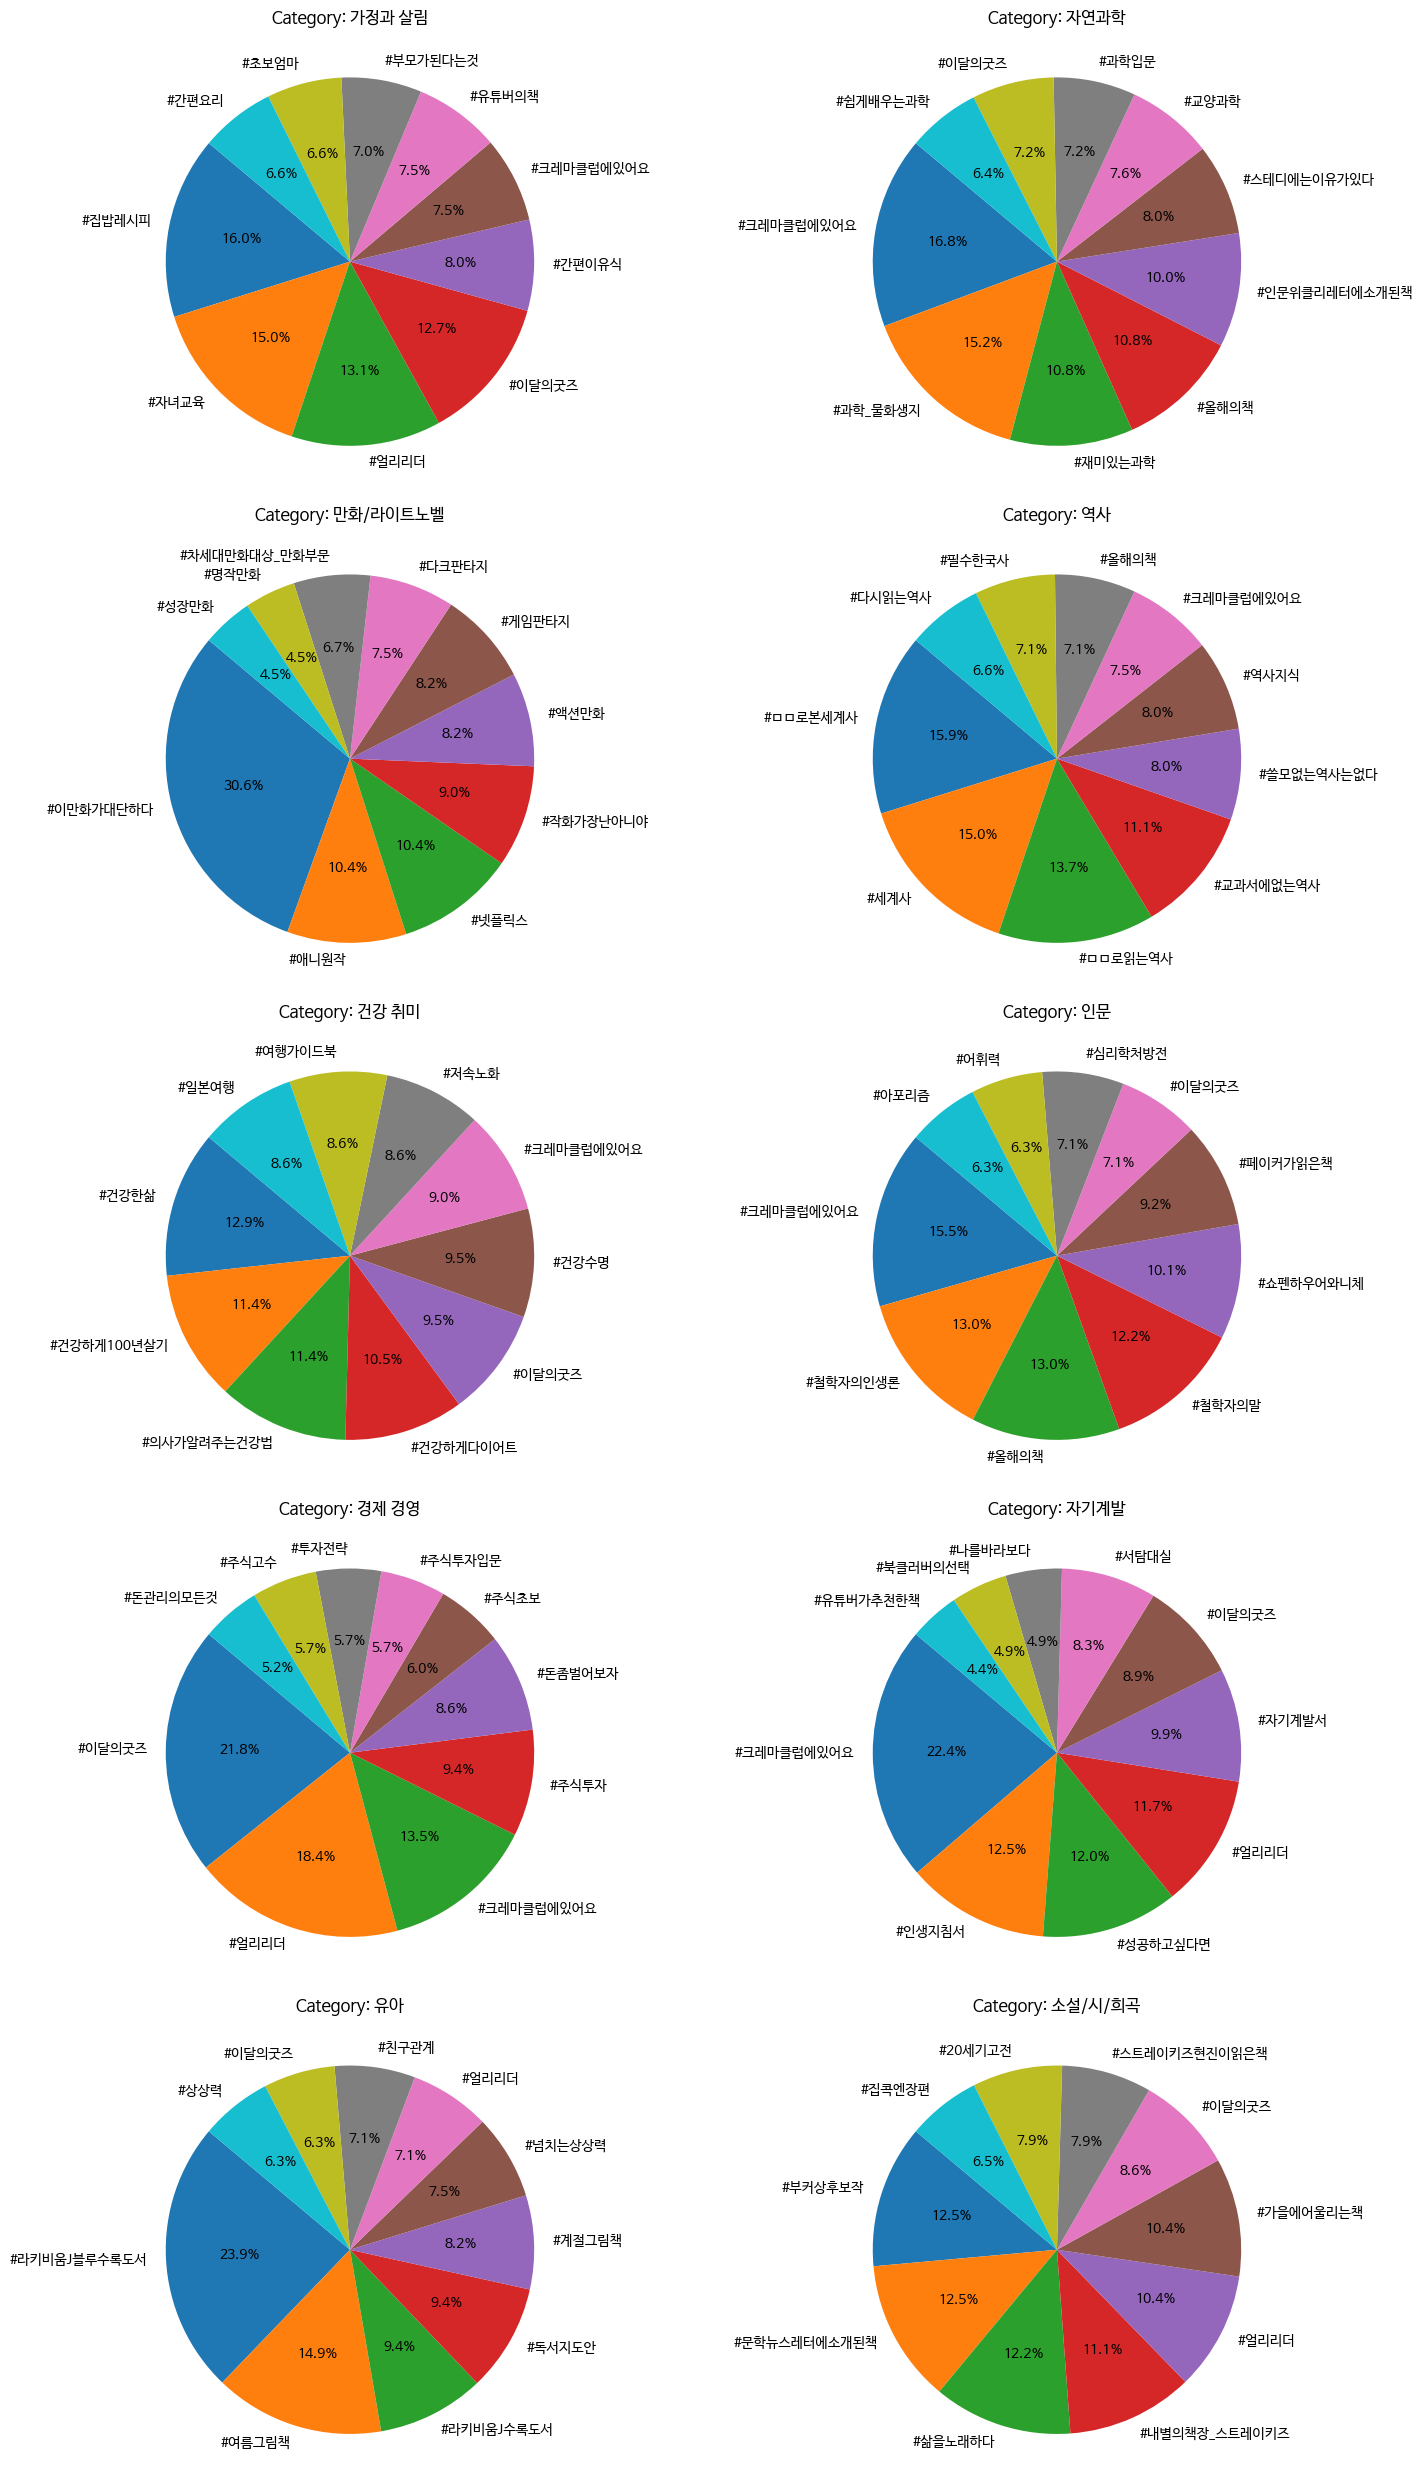

In [56]:
# 카테고리별 키워드 랭킹
category_keyword_counter = {}

for category in yes_df['Category'].unique():
    counter = Counter()
    for keywords in yes_df[yes_df['Category'] == category]['Keywords']:
        keywords_list = ast.literal_eval(keywords)
        counter.update(keywords_list)
    category_keyword_counter[category] = counter.most_common(10)  # 상위 10개 키워드 추출

# 결과 시각화
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 25))  # 5행 2열의 subplot 생성

# 평평한 axes 배열을 1차원으로 변환하여 루프를 통해 사용
axes_flat = axes.flatten()

for i, (category, counter) in enumerate(category_keyword_counter.items()):
    keywords, counts = zip(*counter)
    axes_flat[i].pie(counts, labels=keywords, autopct='%1.1f%%', startangle=140)
    axes_flat[i].set_title(f'Category: {category}')

# 남은 subplot은 숨김 처리
for ax in axes_flat[len(category_keyword_counter):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

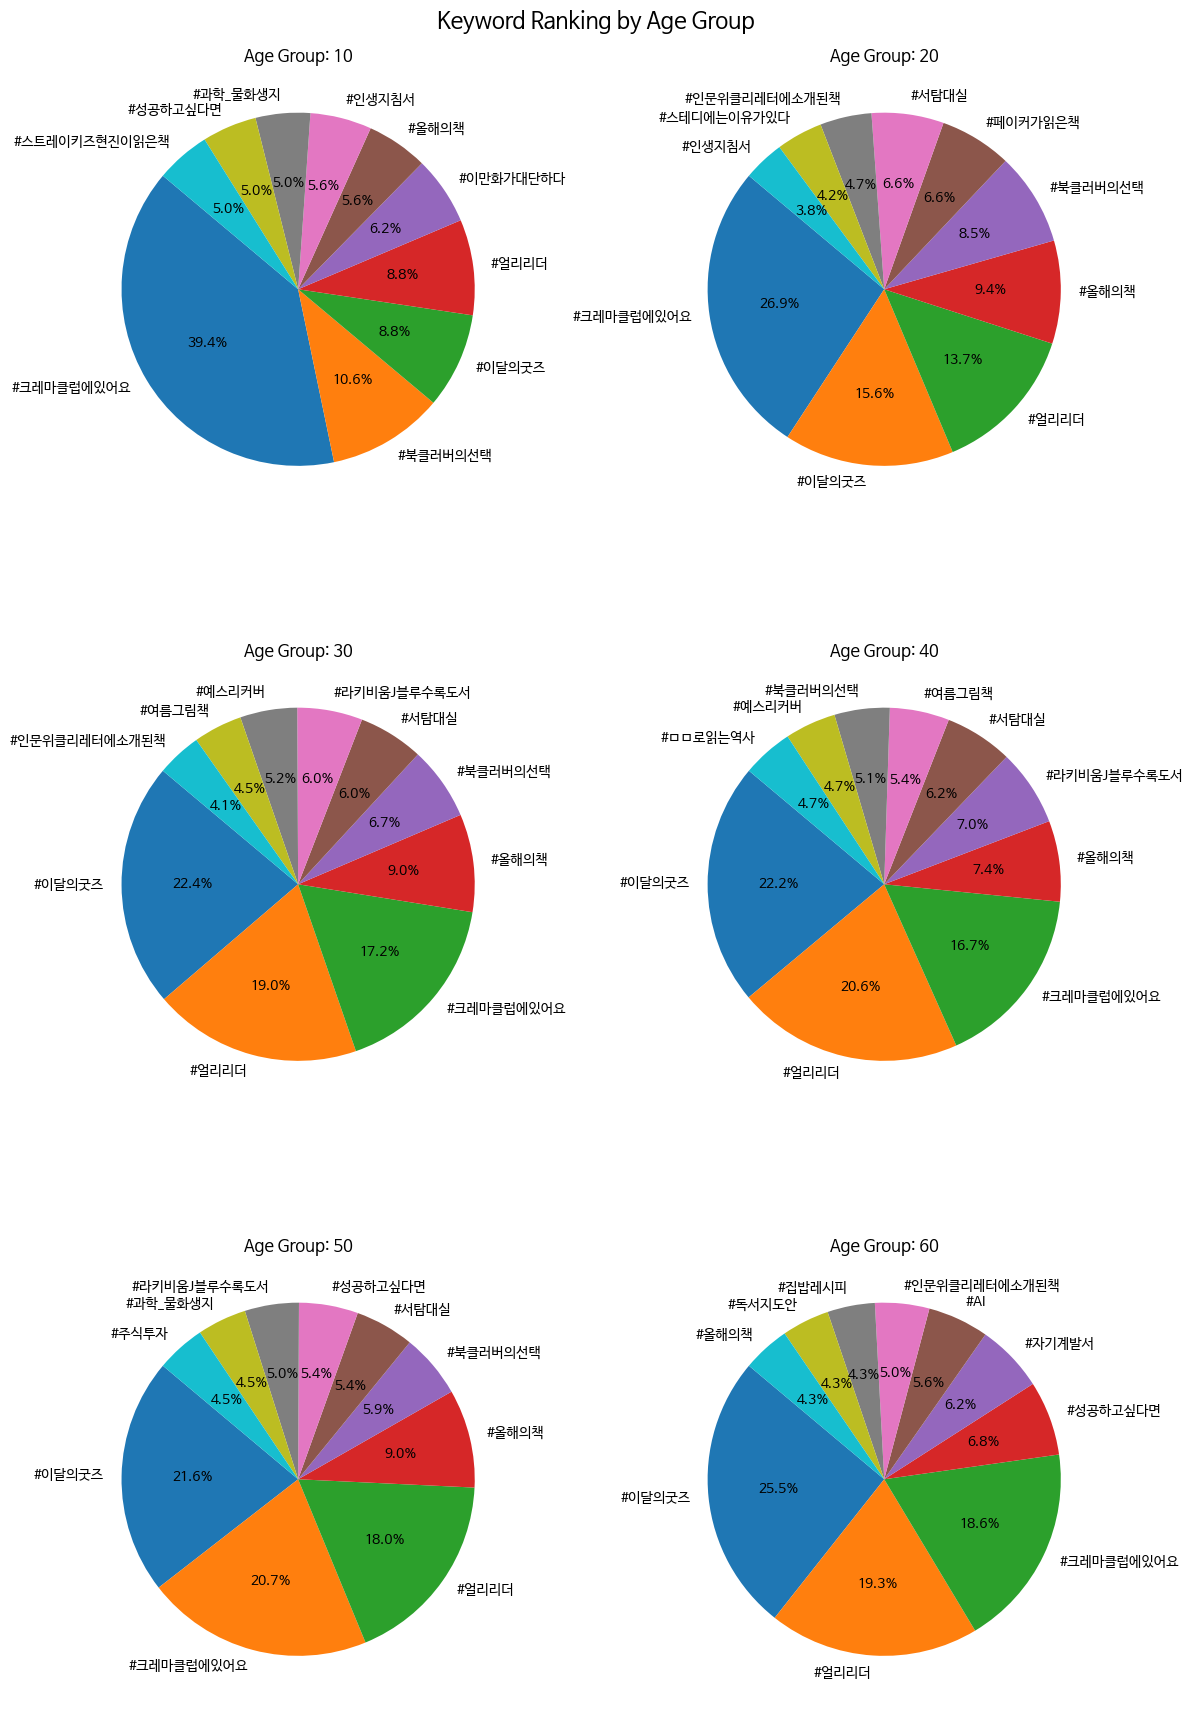

In [91]:
age_keyword_counter = {}

for age in sorted(yes_df['Age'].unique()):
    counter = Counter()
    for keywords in yes_df[yes_df['Age'] == age]['Keywords']:
        keywords_list = ast.literal_eval(keywords)
        counter.update(keywords_list)
    age_keyword_counter[age] = counter.most_common(10)  # 상위 10개 키워드 추출

# 결과 시각화
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 18))

for ax, (age, counter) in zip(axes.flatten(), age_keyword_counter.items()):
    if age in age_keyword_counter:  # 데이터가 있는 경우에만 그래프 그리기
        keywords, counts = zip(*counter)
        ax.pie(counts, labels=keywords, autopct='%1.1f%%', startangle=140)
        ax.set_title(f'Age Group: {age}')
        ax.set_aspect('equal')  # 원형 비율 유지
        ax.set_ylabel('')  # y축 라벨 제거

plt.tight_layout()
plt.suptitle('Keyword Ranking by Age Group', fontsize=16)
plt.show()

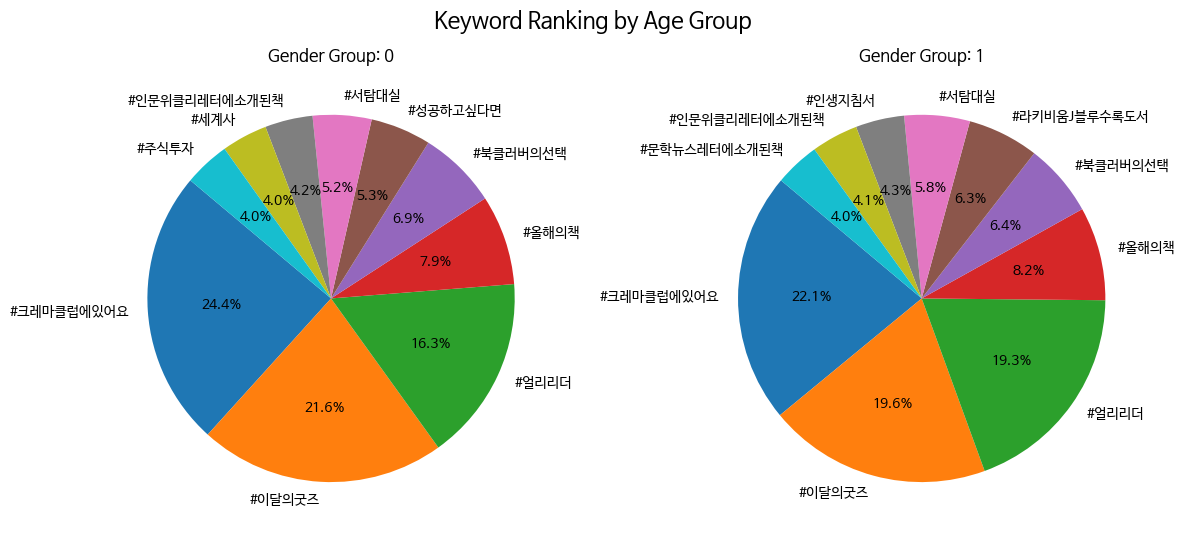

In [9]:
gender_keyword_counter = {}

for gender in sorted(yes_df['Gender'].unique()):
    counter = Counter()
    for keywords in yes_df[yes_df['Gender'] == gender]['Keywords']:
        keywords_list = ast.literal_eval(keywords)
        counter.update(keywords_list)
    gender_keyword_counter[gender] = counter.most_common(10)  # 상위 10개 키워드 추출

# 결과 시각화
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

for ax, (gender, counter) in zip(axes.flatten(), gender_keyword_counter.items()):
    if gender in gender_keyword_counter:  # 데이터가 있는 경우에만 그래프 그리기
        keywords, counts = zip(*counter)
        ax.pie(counts, labels=keywords, autopct='%1.1f%%', startangle=140)
        ax.set_title(f'Gender Group: {gender}')
        ax.set_aspect('equal')  # 원형 비율 유지
        ax.set_ylabel('')  # y축 라벨 제거

plt.tight_layout()
plt.suptitle('Keyword Ranking by Age Group', fontsize=16)
plt.show()

In [113]:
yes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Category      30 non-null     object  
 1   Title         30 non-null     object  
 2   Author        30 non-null     object  
 3   Publisher     30 non-null     object  
 4   Price         30 non-null     int64   
 5   Publish_Date  30 non-null     object  
 6   Sales_Index   30 non-null     int64   
 7   Rating        30 non-null     float64 
 8   Age_Scores    30 non-null     object  
 9   Pages         30 non-null     int64   
 10  Keywords      30 non-null     object  
 11  Gender        30 non-null     int64   
 12  Age           30 non-null     int64   
 13  Comments      30 non-null     object  
 14  month         30 non-null     int64   
 15  Price_Range   30 non-null     category
 16  page_labels   28 non-null     category
dtypes: category(2), float64(1), int64(6), object(8)
memory u

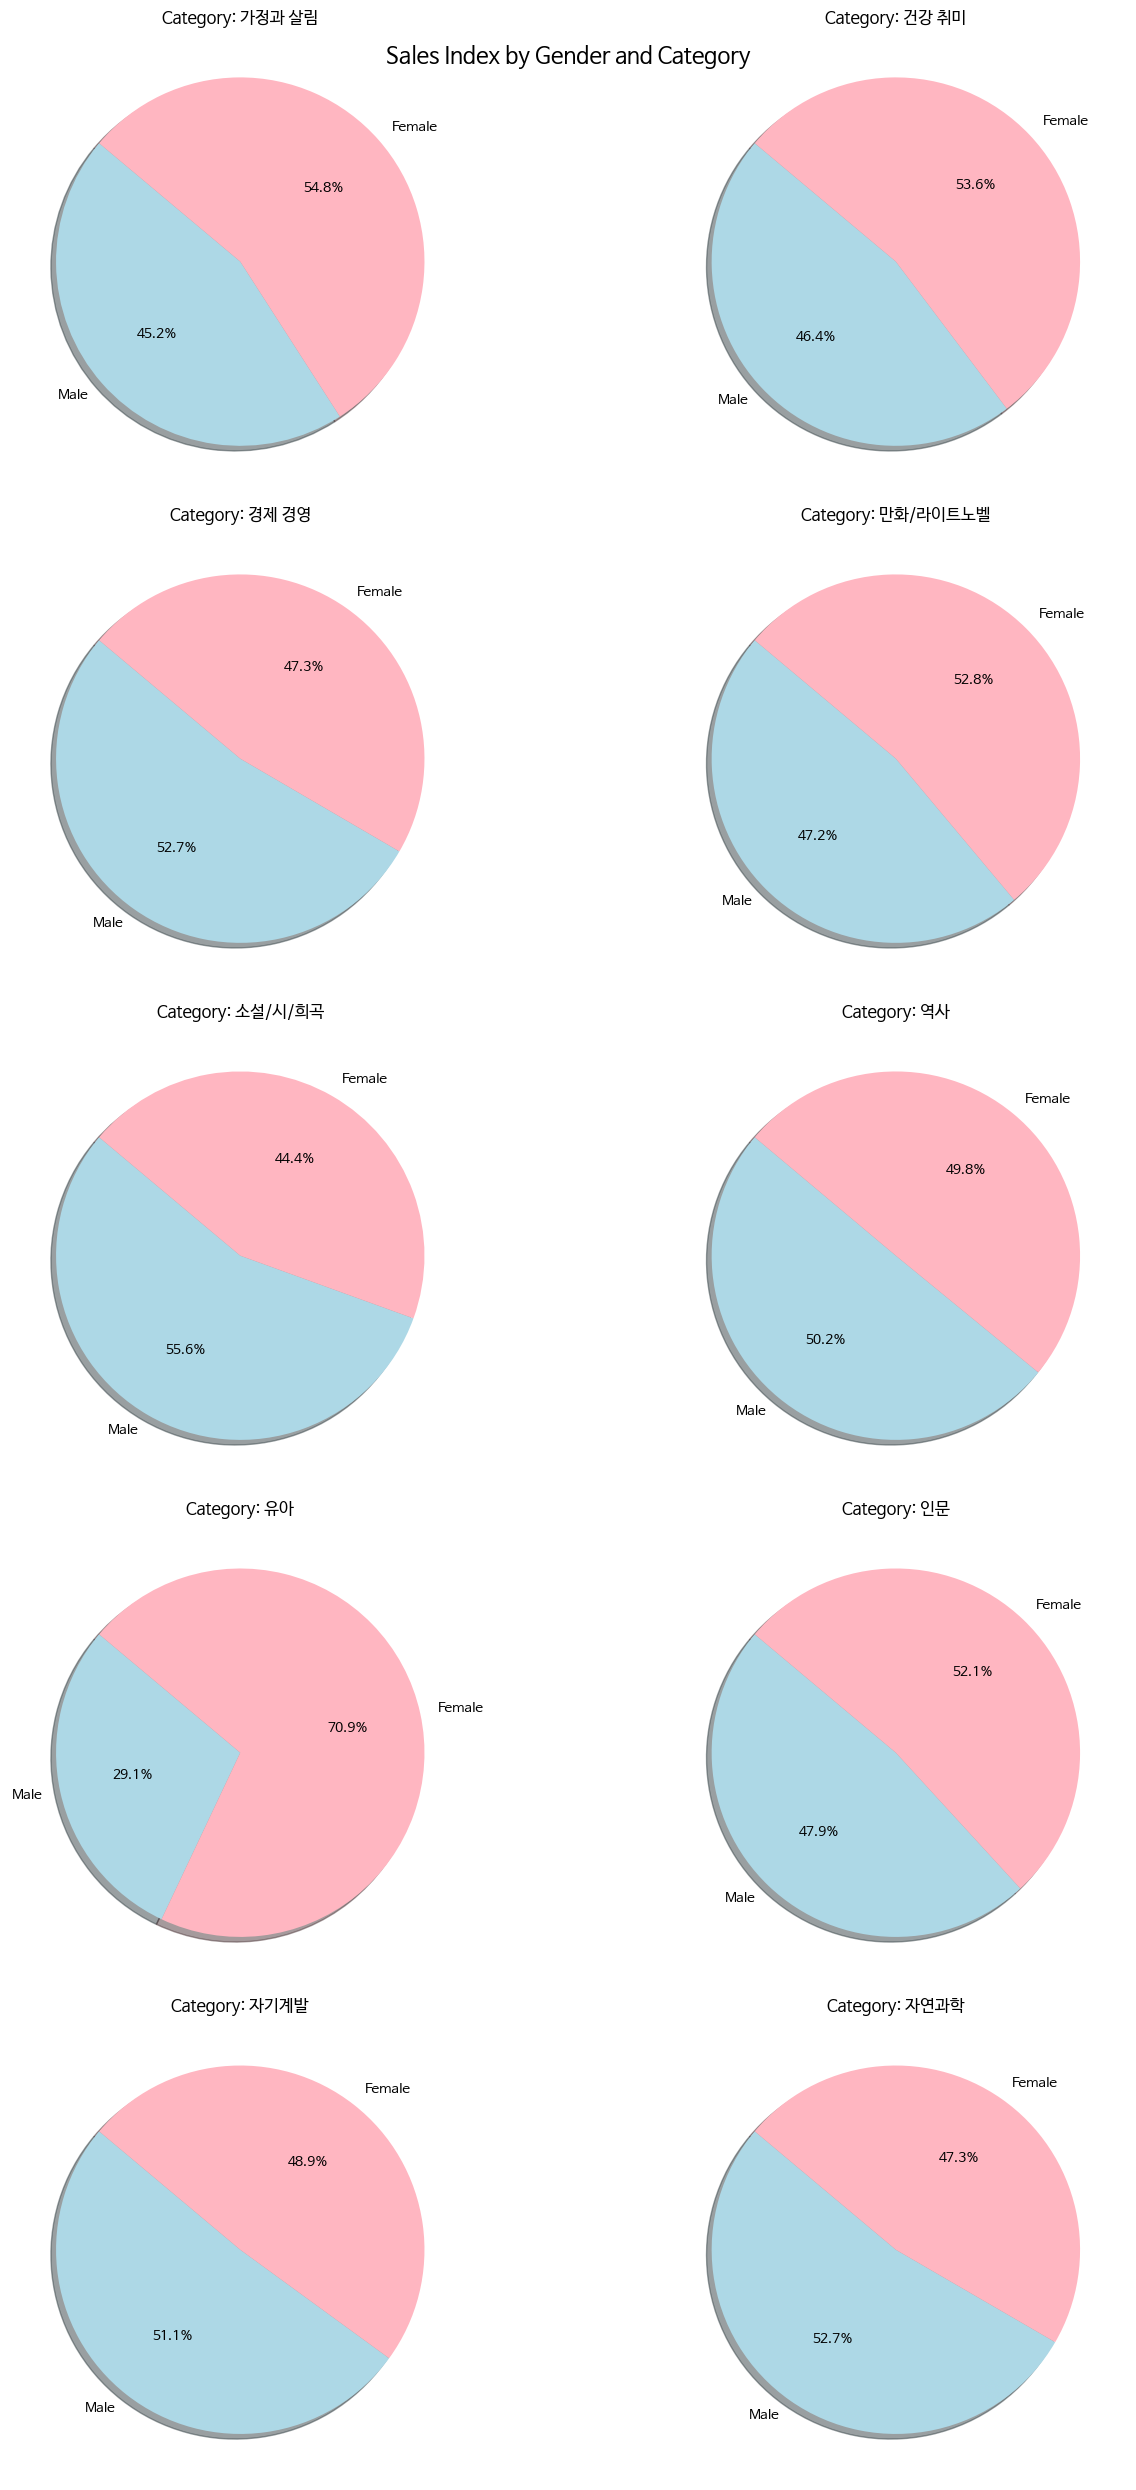

In [78]:
sales_summary = yes_df.groupby(['Category', 'Gender'])['Sales_Index'].sum().unstack()

# 결과 시각화
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(15, 25)) 

if len(sales_summary) % 2 == 1:
    fig.delaxes(axes[-1, -1])  # 홀수 개의 subplot이면 마지막 subplot을 삭제

colors = ['lightblue', 'lightpink']

for ax, (category, row) in zip(axes.flatten(), sales_summary.iterrows()):
    pie = row.plot(kind='pie', ax=ax, labels=['Male', 'Female'], autopct='%1.1f%%', startangle=140, colors=colors, shadow=True)
    ax.set_title(f'Category: {category}')
    ax.set_ylabel('')  # y축 라벨 제거
    ax.set_aspect('equal')  # 파이 그래프의 비율을 원형으로 유지

plt.tight_layout()
plt.suptitle('Sales Index by Gender and Category', fontsize=16)
plt.show()

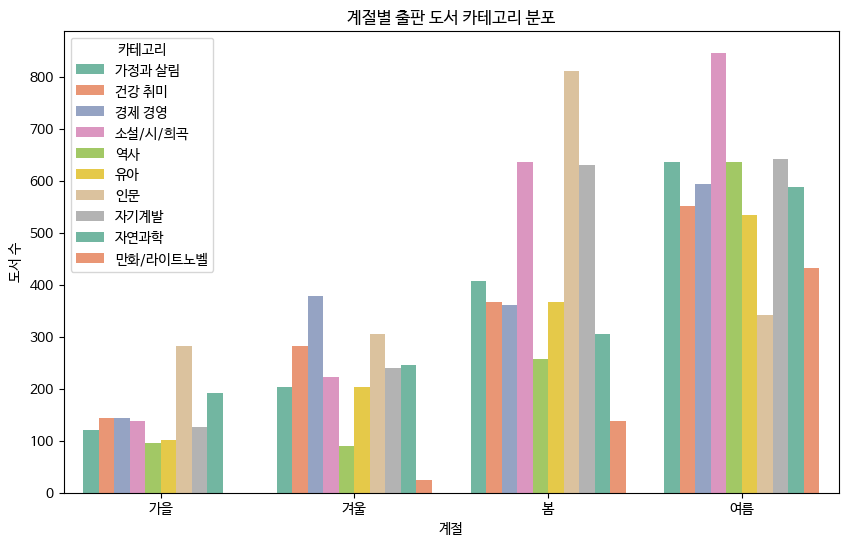

In [13]:
# 출판월 활용 / 계절별 트렌드 반영
season_category_counts = yes_df.groupby(['Season', 'Category']).size().reset_index(name='Count')

# 시각화
plt.figure(figsize=(10, 6))
sns.barplot(data=season_category_counts, x='Season', y='Count', hue='Category', palette='Set2')
plt.title('계절별 출판 도서 카테고리 분포')
plt.xlabel('계절')
plt.ylabel('도서 수')
plt.legend(title='카테고리')
plt.show()

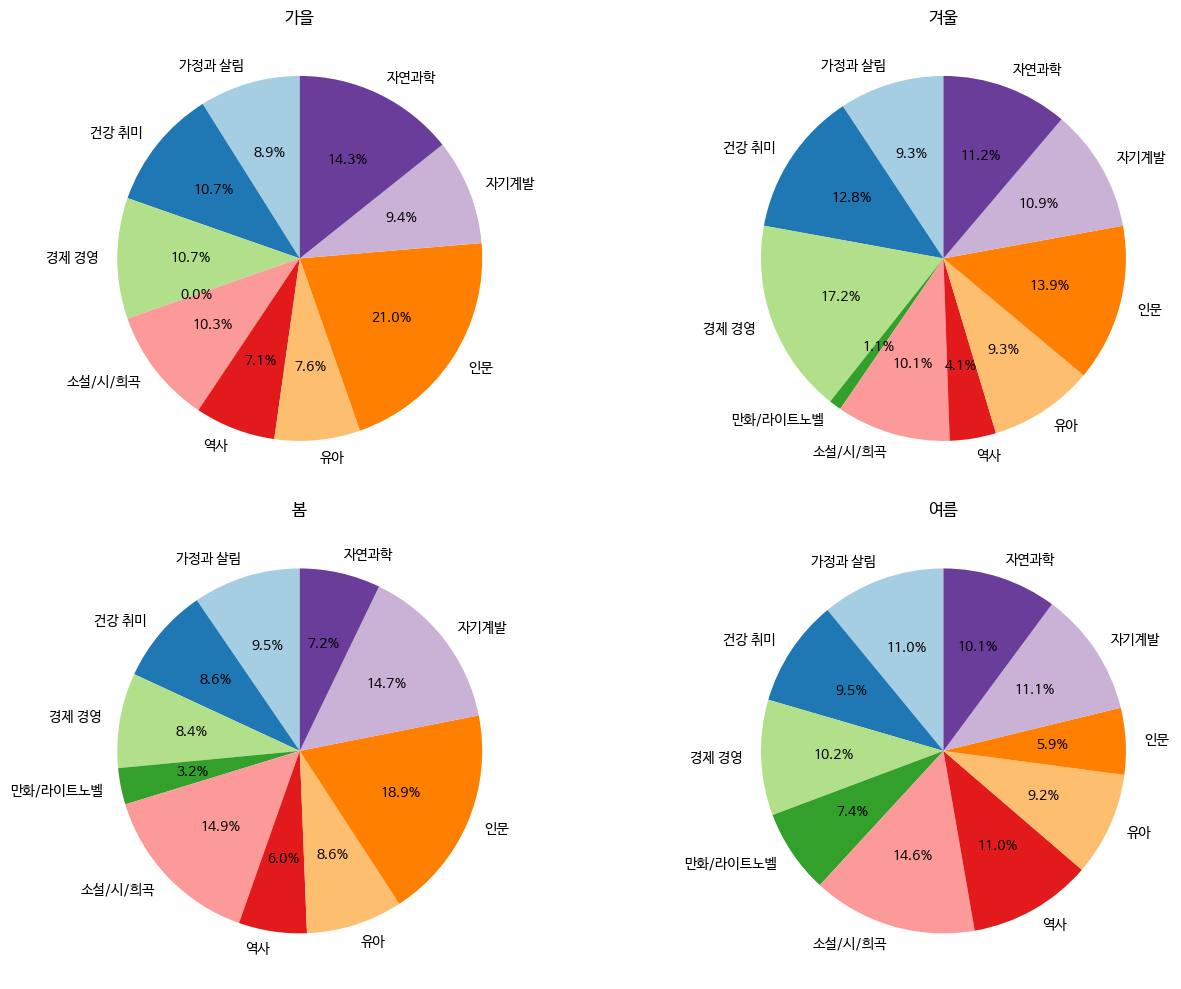

In [18]:
season_category_counts = yes_df.groupby(['Season', 'Category']).size().unstack().fillna(0)

# 파이 그래프 그리기
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for (season, counts), ax in zip(season_category_counts.iterrows(), axes.flatten()):
    counts.plot.pie(ax=ax, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
    ax.set_ylabel('')
    ax.set_title(f'{season}')

plt.tight_layout()
plt.show()

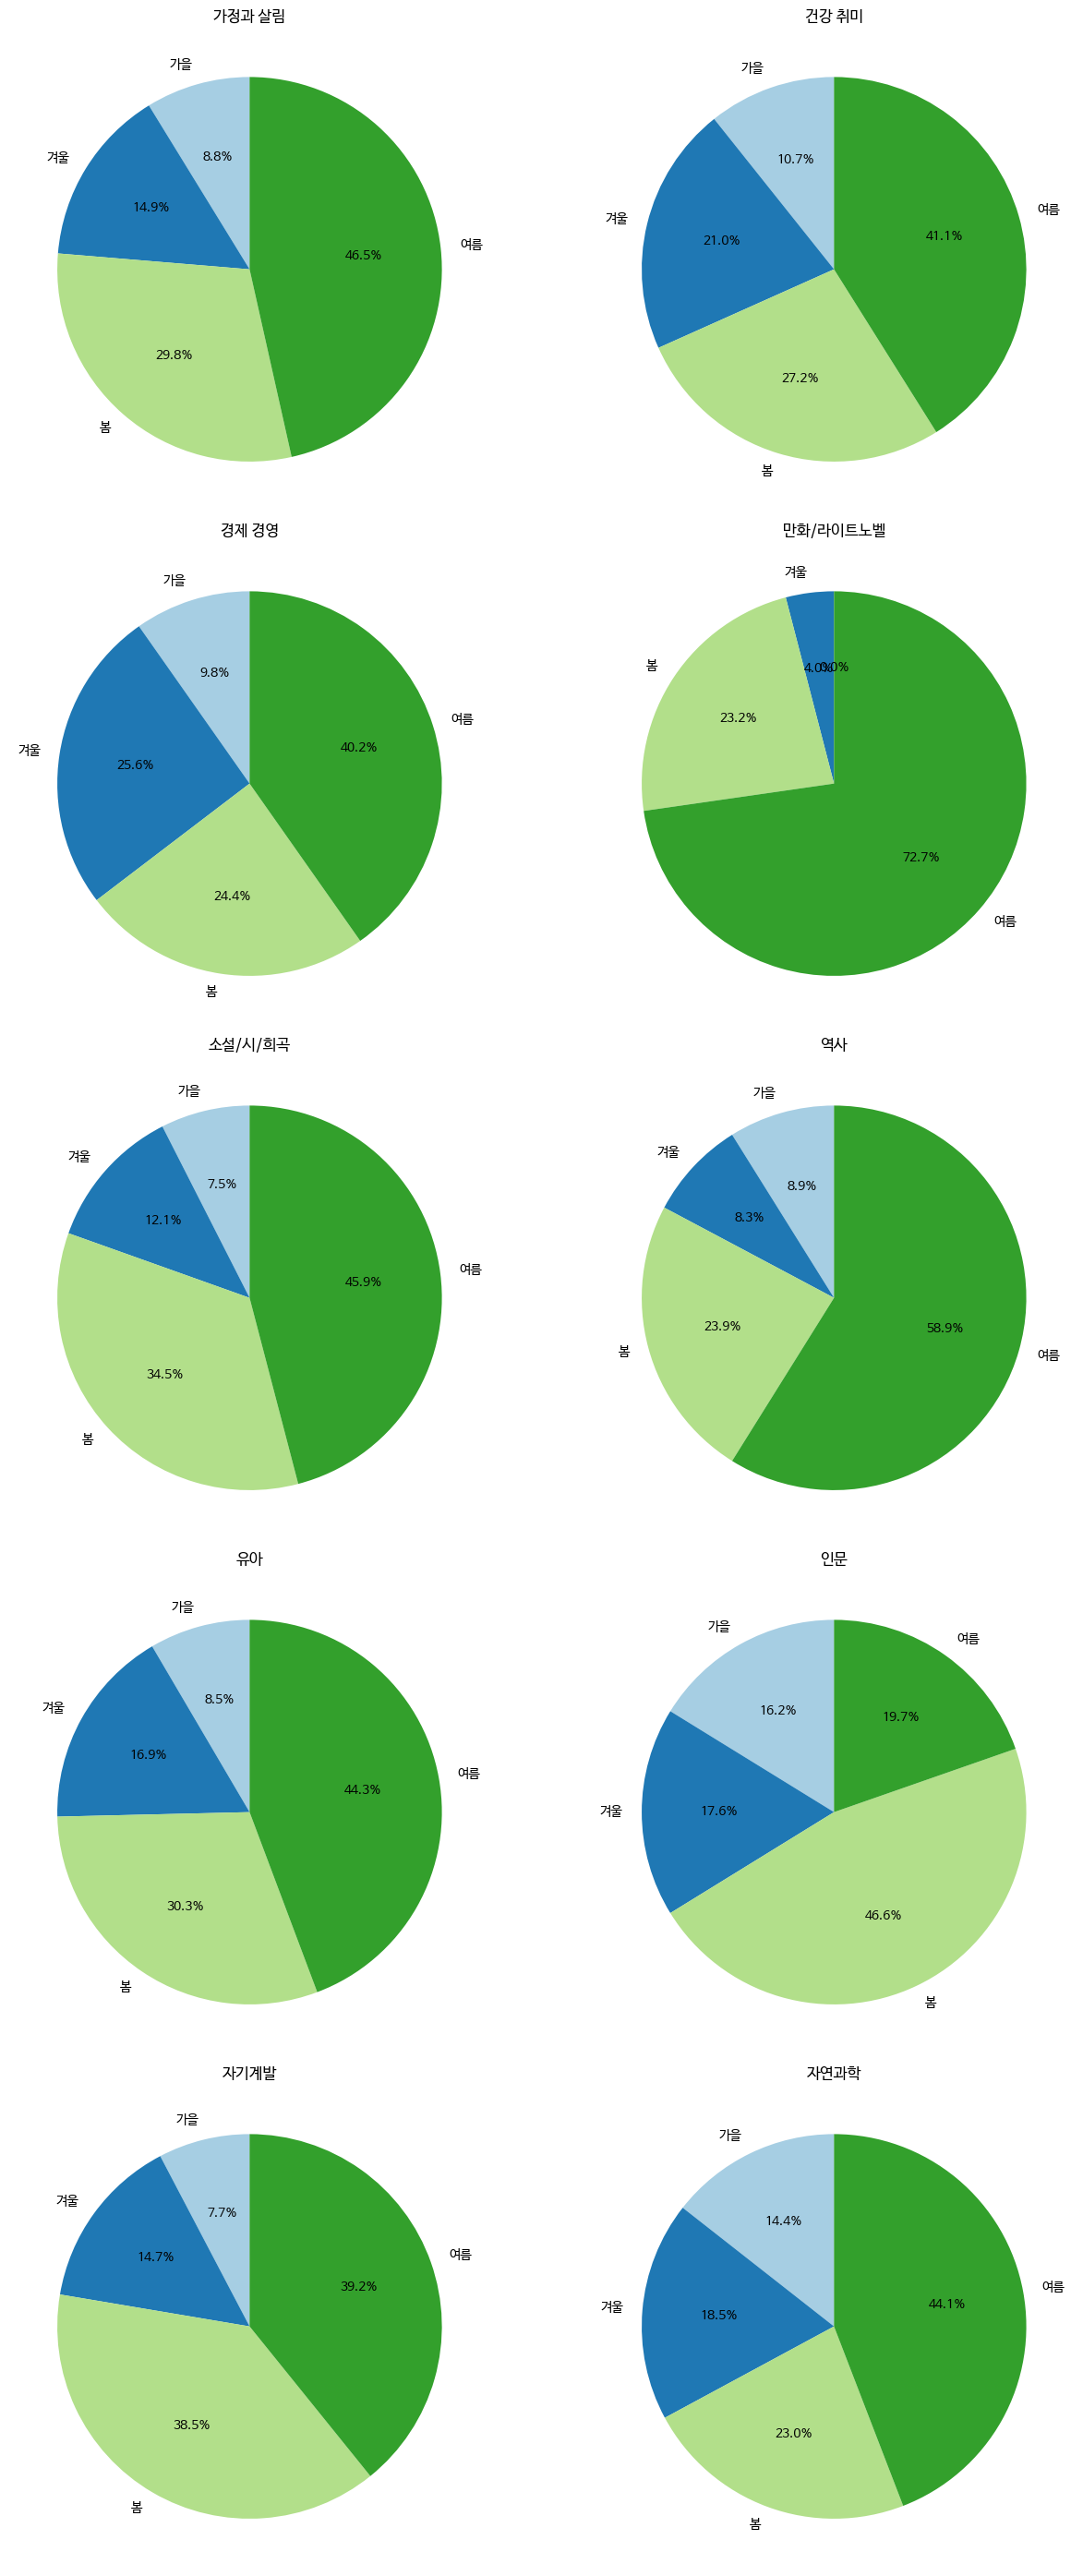

In [24]:
season_category_counts = yes_df.groupby(['Category', 'Season']).size().unstack().fillna(0)

# 파이 그래프 그리기
fig, axes = plt.subplots(5, 2, figsize=(14, 28))

for (category, counts), ax in zip(season_category_counts.iterrows(), axes.flatten()):
    counts.plot.pie(ax=ax, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
    ax.set_ylabel('')
    ax.set_title(f'{category}')

plt.tight_layout()
plt.show()

In [26]:
yes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13620 entries, 0 to 13619
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Year          13620 non-null  int64   
 1   Month         13620 non-null  int64   
 2   Category      13620 non-null  object  
 3   Title         13620 non-null  object  
 4   Author        13620 non-null  object  
 5   Publisher     13620 non-null  object  
 6   Price         13620 non-null  int64   
 7   Publish_Date  13620 non-null  object  
 8   Sales_Index   13620 non-null  int64   
 9   Rating        13620 non-null  float64 
 10  Age_Scores    13620 non-null  object  
 11  Pages         13620 non-null  float64 
 12  Keywords      13620 non-null  object  
 13  Gender        13620 non-null  int64   
 14  Age           13620 non-null  int64   
 15  month         13620 non-null  int64   
 16  Price_Range   13620 non-null  category
 17  page_labels   13620 non-null  category
 18  Season

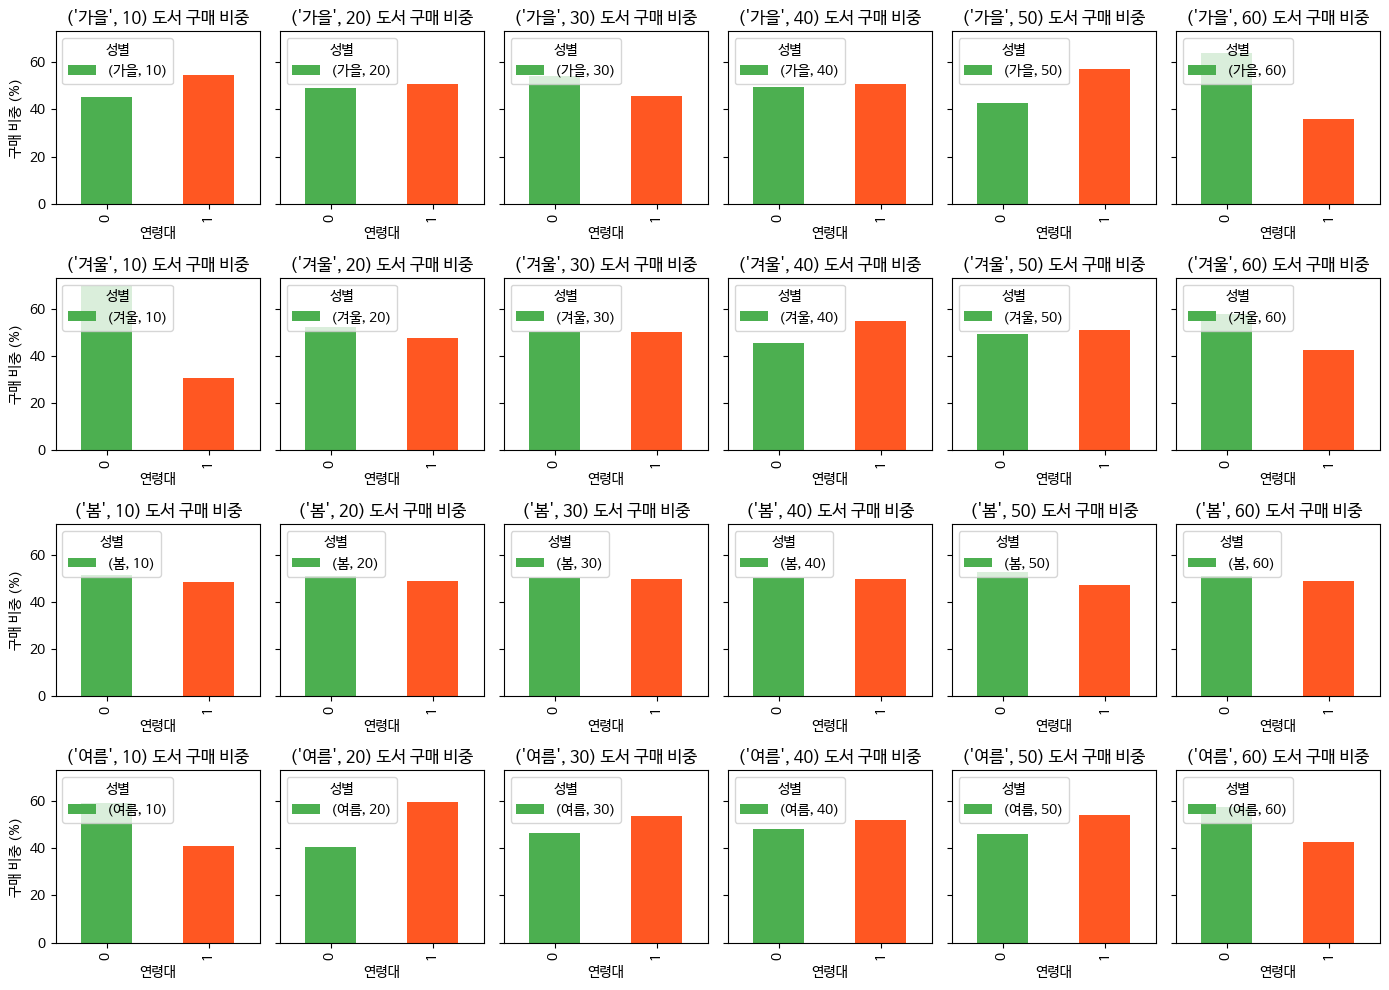

In [31]:
# 그룹화하여 각 그룹의 판매 비중을 계산
season_age_gender_sales = yes_df.groupby(['Season', 'Age', 'Gender'])['Sales_Index'].sum().unstack(fill_value=0)
season_age_gender_sales_percentage = season_age_gender_sales.div(season_age_gender_sales.sum(axis=1), axis=0) * 100

fig, axes = plt.subplots(4, 6, figsize=(14, 10), sharey=True)

for (season, data), ax in zip(season_age_gender_sales_percentage.iterrows(), axes.flatten()):
    data.plot(kind='bar', stacked=True, ax=ax, color=['#4CAF50', '#FF5722'])
    ax.set_title(f'{season} 도서 구매 비중')
    ax.set_ylabel('구매 비중 (%)')
    ax.set_xlabel('연령대')
    ax.legend(title='성별', loc='upper left')

plt.tight_layout()
plt.show()


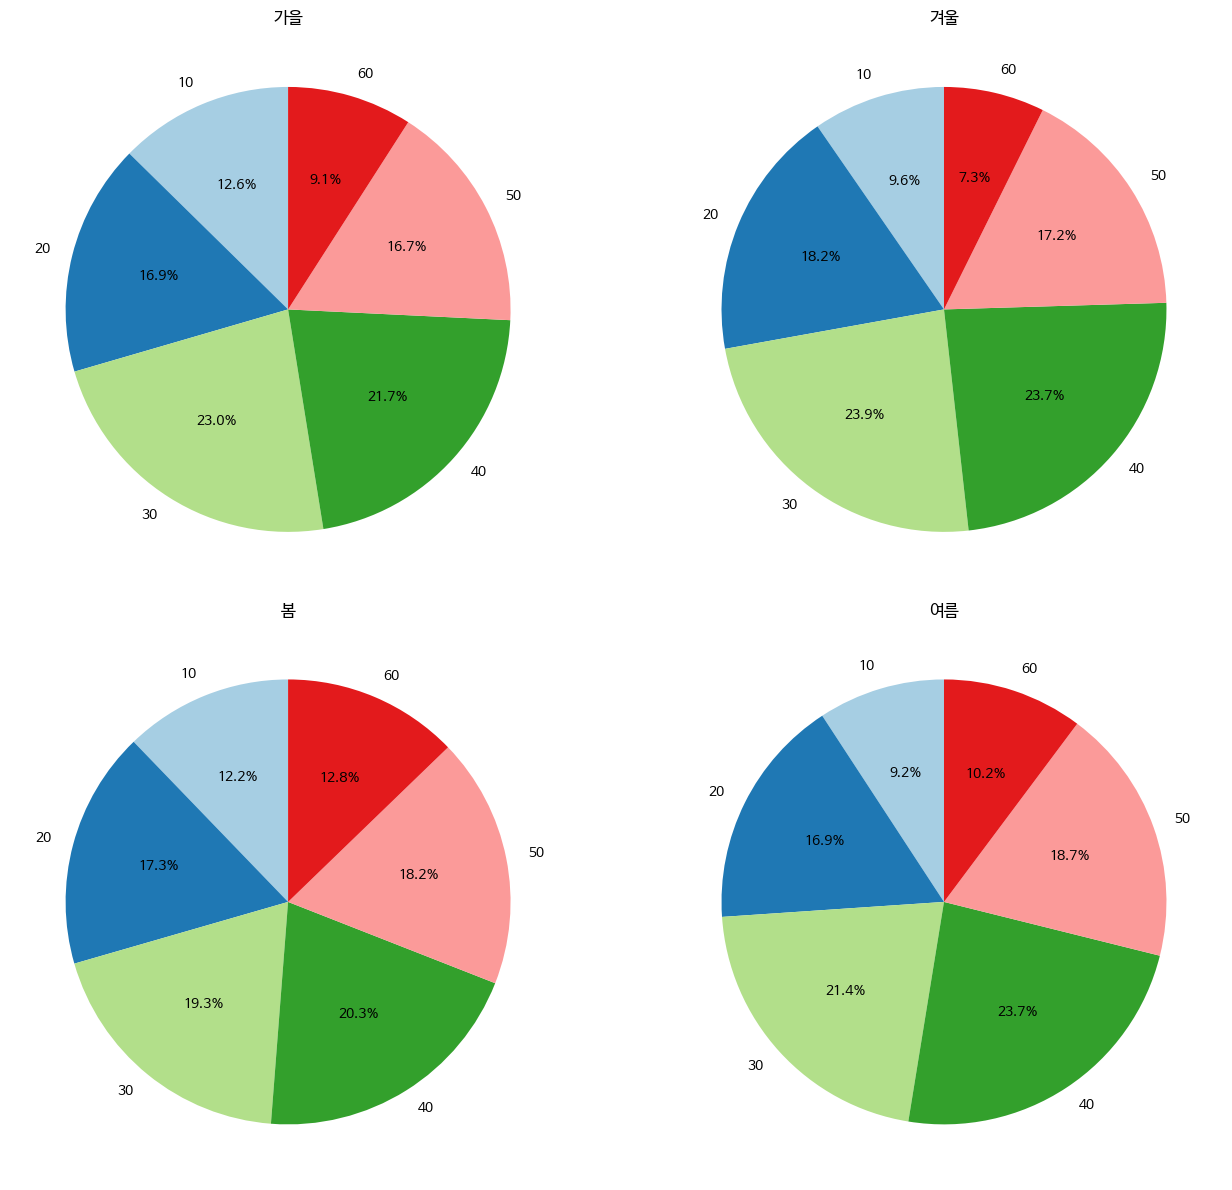

In [35]:
# 연령대별 계절에 따른 도서 구매비중 - 판매지수
season_age_sales = yes_df.groupby(['Season', 'Age'])['Sales_Index'].sum().unstack(fill_value=0)
season_age_sales_percentage = season_age_sales.div(season_age_sales.sum(axis=1), axis=0) * 100

fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 계절별 파이 차트를 그립니다.
for (season, data), ax in zip(season_age_sales_percentage.iterrows(), axes.flatten()):
    ax.pie(data, labels=data.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
    ax.set_title(f'{season}')

plt.tight_layout()
plt.show()